# Import lib

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# The latest CDF library https://spdf.gsfc.nasa.gov/pub/software/cdf/dist/latest/
from spacepy import pycdf

# os.environ["CDF_LIB"] = "C:\\Program Files\\CDF_Distribution\\cdf39_0-dist\\lib"
os.environ["CDF_LIB"] = "/Applications/cdf/cdf39_0-dist/lib"

# sys.path.append('../lib/')
sys.path.append('./lib/')

import juice_cdf_lib as juice_cdf

# Setting and Read CDF file

In [3]:
# *** Parameter set ***
spec_mode = 0                           # 0: low-resoltion   1: high-resolution
cal_mode = 0                            # 0: raw    1: dBm    2: V2    3: V2/Hz
cal = 0                                 # 0: background   1: cal

E_power_min = 1e-4                      # E_power_min: 10e-4 (--> -144 dBm)
f_max = 45000                           # f_max [kHz]
f_min = 80                              # f_min [kHz]
p_max = 8.0                             # background: 8   CAL: 10
p_min = 1.5                             # background: 2   CAL: 5

cf = 0.0
if cal_mode == 1:
    cf = -104.1                         # Conversion factor: Raw value @ ADC input to dBm
p_max = p_max + cf/10
p_min = p_min + cf/10
if spec_mode == 1:
    p_max = p_max - 1.5
    p_min = p_min - 1.5

# *** Folder set ***
work_dir = '/Users/user/0-python/JUICE_notebook/ql/'   # Plot dump folder
data_dir = '/Users/user/0-python/JUICE_GS_test/cdf/'   # Data folder

In [4]:
# *** NECP ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230419T135849-20230419T141229_V01___RPR1_52000000_2023.109.16.17.21.607.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230419T141231-20230419T141402_V01___RPR1_52000001_2023.109.17.51.54.600.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100925_V01___RPR1_52000010_2023.150.10.40.53.663.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100927-20230530T100937_V01___RPR1_52000011_2023.150.10.41.53.508.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230530T100326-20230530T100925_V01___RPR1_52000010_2023.150.10.40.53.663.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T120759-20230601T120857_V01___RPR1_52000015_2023.152.12.32.12.471.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T121435-20230601T121533_V01___RPR1_52000016_2023.152.13.14.38.473.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122138-20230601T122236_V01___RPR1_52000017_2023.152.13.55.02.539.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T122707-20230601T122805_V01___RPR1_52000018_2023.152.14.35.37.467.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20230601T123416-20230601T123514_V01___RPR1_52000019_2023.152.15.15.55.483.cdf'

# *** High-samp rate ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000304-20000101T000308_V01___TMIDX_00000_32.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000150-20000101T000154_V01___TMIDX_00000_64.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000355-20000101T000359_V01___TMIDX_00000_96.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000555-20000101T000559_V01___TMIDX_00000_128.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000725-20000101T000730_V01___TMIDX_00000_256.bin.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000131-20000101T000139_V01___TMIDX_00000_512.bin.cdf'

# *** High-samp rate: Tsuchiya ***
data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000031-20000101T000940_V01___HF_SID2_064_20230624-1139.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000050-20000101T000454_V01___HF_SID2_032_20230624-1132.ccs.cdf'
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000111-20000101T000150_V01___HF_SID2_128_20230624-1306.ccs.cdf'

# *** Ver.2 ***
# data_name = 'JUICE_L1a_RPWI-HF-SID2_20000101T000459-20000101T000700_V01___HF_20210920-1007.ccs.cdf'

cdf_file = data_dir + data_name
# %ls $data_dir
%ls $cdf_file

/Users/user/0-python/JUICE_GS_test/cdf/JUICE_L1a_RPWI-HF-SID2_20000101T000050-20000101T000454_V01___HF_SID2_032_20230624-1132.ccs.cdf


# get SID-2 data

In [5]:
cdf = pycdf.CDF(cdf_file)
data = juice_cdf.juice_getdata_hf_sid02(cdf)

# Raw data

2000/01/01


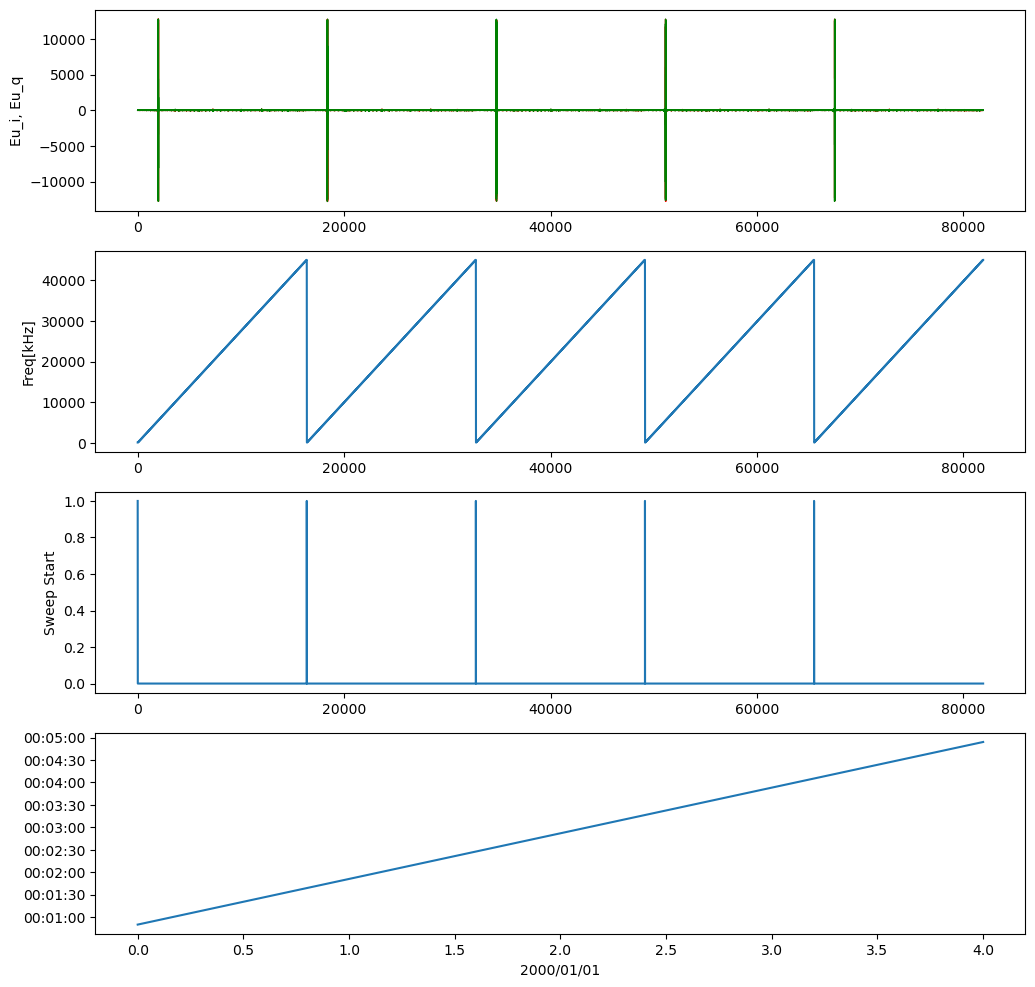

In [6]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(4, 1, 1)
ax2 = fig.add_subplot(4, 1, 2)
ax3 = fig.add_subplot(4, 1, 3)
ax4 = fig.add_subplot(4, 1, 4)

ax1.plot(np.ravel(data.Eu_i), '-r', linewidth=1)
ax1.plot(np.ravel(data.Eu_q), '-g', linewidth=1)
ax2.plot(np.ravel(data.frequency))
ax3.plot(np.ravel(data.sweep_start))
ax4.plot(np.ravel(data.epoch))
date = data.epoch[0]
date = date.strftime('%Y/%m/%d')
print(date)

ax1.set_ylabel('Eu_i, Eu_q')
ax2.set_ylabel('Freq[kHz]')
ax3.set_ylabel('Sweep Start')
ax4.set_xlabel(date)

# xlim=[458239, 458241]
# ax1.set_xlim(xlim)
# ax2.set_xlim(xlim)
# ax3.set_xlim(xlim)
plt.show()
png_fname = work_dir+data_name+'_raw.png'
fig.savefig(png_fname)


In [7]:
# Sped mode:  0 - low resolution,  1 - high resolution  
spec = juice_cdf.juice_getspec_hf_sid02(data, spec_mode)

spec.Eu_power = spec.Eu_power * 10**(cf/10)
spec.Ev_power = spec.Ev_power * 10**(cf/10)
spec.Ew_power = spec.Ew_power * 10**(cf/10)
spec.Eu_power_dB = 10.0 * np.log10(spec.Eu_power)
spec.Ev_power_dB = 10.0 * np.log10(spec.Ev_power)
spec.Ew_power_dB = 10.0 * np.log10(spec.Ew_power)

n_time = spec.Eu_power.shape[1]
n_freq = spec.Eu_power.shape[0]
print(spec.Eu_power.shape, n_time, n_freq)

(array([    0, 16384, 32768, 49152, 65536, 81920]),)
[ 0 0 2000-01-01 00:00:50.049576 ] length: 16384 == 32 * 512
[ 1 1 2000-01-01 00:01:51.049591 ] length: 16384 == 32 * 512
[ 2 2 2000-01-01 00:02:52.049561 ] length: 16384 == 32 * 512
[ 3 3 2000-01-01 00:03:53.049561 ] length: 16384 == 32 * 512
[ 4 4 2000-01-01 00:04:54.049561 ] length: 16384 == 32 * 512
(512, 5) 5 512


# Spectra

# LOG: Frequency - Power

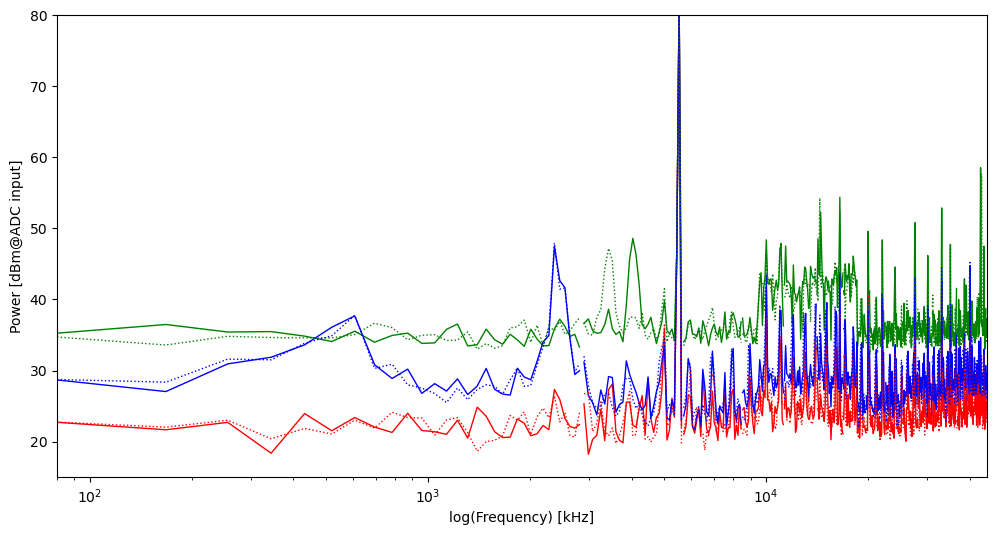

"\nfig = plt.figure(figsize=(12, 12))\nax1 = fig.add_subplot(3, 1, 1)\nax2 = fig.add_subplot(3, 1, 2)\nax3 = fig.add_subplot(3, 1, 3)\n\nfor i in range(spec.n_step):\n    ax1.plot(np.log10(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0]), spec.Eu_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-r', linewidth=1)\n    ax2.plot(np.log10(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0]), spec.Ev_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-g', linewidth=1)\n    ax3.plot(np.log10(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0]), spec.Ew_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-b', linewidth=1)\n\nax3.set_xlabel('Frequency [kHz]')\nax1.set_ylabel('Power Eu [dBm@ADC input]')\nax2.set_ylabel('Power Ev [dBm@ADC input]')\nax3.set_ylabel('Power Ew [dBm@ADC input]')\n"

In [8]:
fig = plt.figure(figsize=(12, 6))

for i in range(spec.n_step):
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Eu_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,0], '-r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ev_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,0], '-g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ew_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,0], '-b', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Eu_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ev_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ew_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':b', linewidth=1)

plt.xlabel('log(Frequency) [kHz]')
plt.xscale('log')
plt.xlim(f_min, f_max)

plt.ylabel('Power [dBm@ADC input]')
plt.ylim(10*p_min, 10*p_max)

plt.show()
png_fname = work_dir+data_name+'_spec-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec-log_h.png'
fig.savefig(png_fname)

"""
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

for i in range(spec.n_step):
    ax1.plot(np.log10(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0]), spec.Eu_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-r', linewidth=1)
    ax2.plot(np.log10(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0]), spec.Ev_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-g', linewidth=1)
    ax3.plot(np.log10(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0]), spec.Ew_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-b', linewidth=1)

ax3.set_xlabel('Frequency [kHz]')
ax1.set_ylabel('Power Eu [dBm@ADC input]')
ax2.set_ylabel('Power Ev [dBm@ADC input]')
ax3.set_ylabel('Power Ew [dBm@ADC input]')
"""

# Linear: Frequency - Power diagram

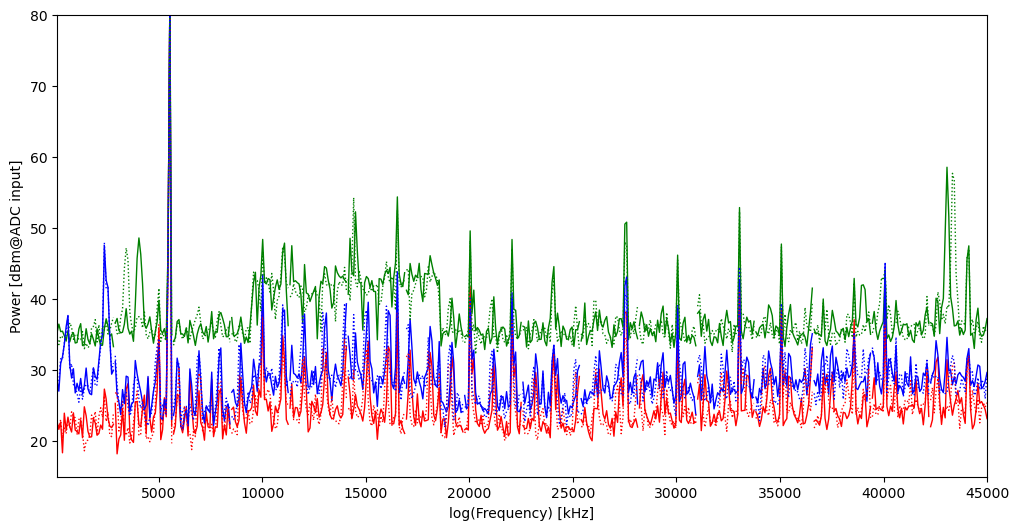

"\nfig = plt.figure(figsize=(12, 12))\nax1 = fig.add_subplot(3, 1, 1)\nax2 = fig.add_subplot(3, 1, 2)\nax3 = fig.add_subplot(3, 1, 3)\n\nfor i in range(spec.n_step):\n    ax1.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Eu_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-r', linewidth=1)\n    ax2.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ev_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-g', linewidth=1)\n    ax3.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ew_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-b', linewidth=1)\n\nax3.set_xlabel('Frequency [kHz]')\nax1.set_ylabel('Power Eu [dBm@ADC input]')\nax2.set_ylabel('Power Ev [dBm@ADC input]')\nax3.set_ylabel('Power Ew [dBm@ADC input]')\n"

In [9]:
fig = plt.figure(figsize=(12, 6))

for i in range(spec.n_step):
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Eu_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,0], '-r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ev_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,0], '-g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ew_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,0], '-b', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Eu_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':r', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ev_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':g', linewidth=1)
    plt.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], spec.Ew_power_dB[i*spec.n_samp:(i+1)*spec.n_samp,n_time-1], ':b', linewidth=1)


plt.xlabel('log(Frequency) [kHz]')
plt.xlim(f_min, f_max)

plt.ylabel('Power [dBm@ADC input]')
plt.ylim(10*p_min, 10*p_max)

plt.show()
png_fname = work_dir+data_name+'_spec.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_spec_h.png'
fig.savefig(png_fname)

"""
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

for i in range(spec.n_step):
    ax1.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Eu_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-r', linewidth=1)
    ax2.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ev_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-g', linewidth=1)
    ax3.plot(spec.frequency[i*spec.n_samp:(i+1)*spec.n_samp,0], spec.Ew_power_dBm[i*spec.n_samp:(i+1)*spec.n_samp,0], '-b', linewidth=1)

ax3.set_xlabel('Frequency [kHz]')
ax1.set_ylabel('Power Eu [dBm@ADC input]')
ax2.set_ylabel('Power Ev [dBm@ADC input]')
ax3.set_ylabel('Power Ew [dBm@ADC input]')
"""

# LOG: Frequency - Time diagram

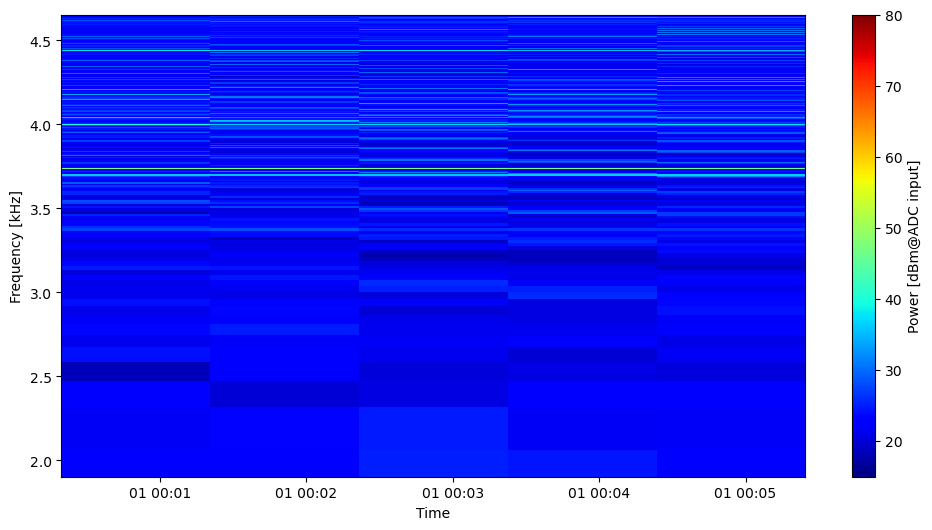

In [10]:
# import matplotlib.colors as colors  # import it to display in logscale

fig = plt.figure(figsize=(12, 6))

mesh = plt.pcolormesh(spec.epoch, np.log10(spec.frequency), spec.Eu_power_dB, vmin=p_min*10, vmax=p_max*10, cmap='jet')
plt.colorbar(mesh, label='Power [dBm@ADC input]')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time')
plt.ylim(np.log10(f_min), np.log10(f_max))

png_fname = work_dir+data_name+'_FT-log.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT-log_h.png'
# fig.savefig(png_fname)

# Linear: Frequency - Time diagram

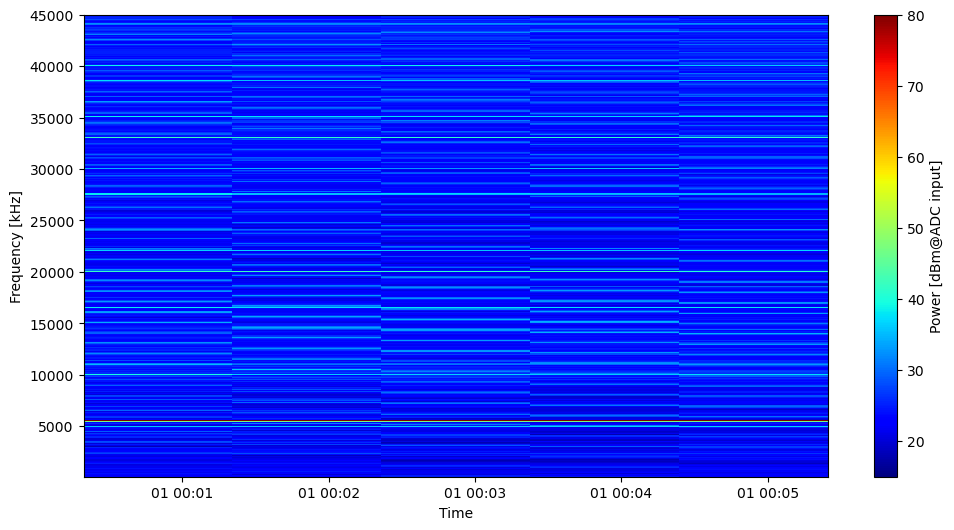

In [11]:
# import matplotlib.colors as colors  # import it to display in logscale

fig = plt.figure(figsize=(12, 6))
mesh = plt.pcolormesh(spec.epoch, spec.frequency, spec.Eu_power_dB, vmin=p_min*10, vmax=p_max*10, cmap='jet')
plt.colorbar(mesh, label='Power [dBm@ADC input]')
plt.ylabel('Frequency [kHz]')
plt.xlabel('Time')
plt.ylim(f_min, f_max)

png_fname = work_dir+data_name+'_FT.png'
if (spec_mode>0):
    png_fname = work_dir+data_name+'_FT_h.png'
# fig.savefig(png_fname)